# Functional Encryption - Classification and information leakage


 
### Purpose

In part 5 & 6 we have used Fixed Precision from Pysyft. We will deepen our analysis by pointing that all weights don't need the same precision as they have different amplitudes. More precisely, we can't have truncation in FE so we want all weights to be integers. We will assess how to modify the inputs and how to cap layers values (which are now intergers) to have the smaller outputs on which presumably we should apply the discrete log to decode the values.

# 1 Quadratic model to fix precision


In [1]:
PREC_FRAC = 3

Load torch and syft packages

In [2]:
# Allow to load packages from parent
import sys, os
sys.path.insert(1, os.path.realpath(os.path.pardir))

In [3]:
import torch
import syft as sy
hook = sy.TorchHook(torch)

In [4]:
from math import log2, ceil

import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as utils

import learn
from learn import main, train, test, show_results, show_confusion_matrix
from learn.models import QuadNet

Let's load the quadratic model that we saved in Part 4! _Be sure that the path and file name match._

In [5]:
class QuadNet(nn.Module):
    def __init__(self, output_size):
        super(QuadNet, self).__init__()
        self.proj1 = nn.Linear(784, 40)
        self.diag1 = nn.Linear(40, output_size, bias=False)

    def forward(self, x):
        x = x.view(-1, 784)
        x = self.proj1(x)
        x = x * x
        x = self.diag1(x)
        return F.log_softmax(x, dim=1)

    def transform(self, x):
        """Same as forward but without the log_softmax"""
        x = x.view(-1, 784)
        x = self.proj1(x)
        x = x * x
        x = self.diag1(x)
        return x

In [6]:
model = QuadNet(26)
path = '../data/models/quad_char_0_01.pt'
model.load_state_dict(torch.load(path))
model.eval()

QuadNet(
  (proj1): Linear(in_features=784, out_features=40, bias=True)
  (diag1): Linear(in_features=40, out_features=26, bias=False)
)

We will now convert the model into fixed precision, look how the `diag1.bias` changes for example!

In [7]:
model.proj1.bias.data[:10]

tensor([ 0.0024, -0.0146, -0.0153, -0.0086, -0.0090,  0.0059,  0.0074, -0.0120,
         0.0072,  0.0014])

In [8]:
model.fix_precision(precision_fractional=PREC_FRAC)

QuadNet(
  (proj1): Linear(in_features=784, out_features=40, bias=True)
  (diag1): Linear(in_features=40, out_features=26, bias=False)
)

In [9]:
print(model.proj1.bias.child.child[:10])

tensor([  2, -14, -15,  -8,  -8,   5,   7, -12,   7,   1])


Here is an analysis of the weigh distribution

In [10]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def print_hist(data):
    x = data.view(-1).abs()
    # the histogram of the data
    n, bins, patches = plt.hist(x, 50, density=True, facecolor='g', alpha=0.75)
    plt.xlabel('Weight amplitude')
    plt.ylabel('Probability')
    plt.title('Weight amplitude distribution')
    #plt.axis([40, 160, 0, 0.01])
    plt.grid(True)
    plt.show()
    
    
def print_data(data):
    ax = sns.heatmap(data, linewidth=0.5)
    plt.show()

In [11]:
class Parser:
    """Parameters for the testing"""
    def __init__(self):
        self.test_batch_size = 10

In [12]:
model = QuadNet(26)
model.load_state_dict(torch.load(path))
model.eval()

torch.manual_seed(1)
args = Parser()

data = learn.load_data()
train_data, train_target_char, train_target_family, test_data, test_target_char, test_target_family = data
test_target = test_target_char
test_dataset = learn.build_tensor_dataset(test_data, test_target)
test_loader = utils.DataLoader(
    test_dataset,
    batch_size=args.test_batch_size, shuffle=True
)

Training set 60000 items
Testing set  10000 items


In [13]:
def test(model, test_loader, data_prec, data_comp):
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data = (data / 2**data_comp).fix_precision(precision_fractional=data_prec).child.child # <-- This is new
            output = model.transform(data) # <-- Not calling forward to avoid the log_softmax
            pred = output.argmax(1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    acc = 100. * correct / len(test_loader.dataset)
    print('\nTest set: Accuracy: {}/{} ({:.2f}%)\n'.format(
        correct, len(test_loader.dataset), acc))
    
    return acc

In [14]:
from math import ceil

In [15]:
def test_compression(prec, comp, rm_outlier_frac=100, show_distrib=False):
    model = QuadNet(26)
    model.load_state_dict(torch.load(path))
    model.eval()

    data_prec, proj_prec, diag_prec = prec
    data_comp, proj_comp, diag_comp = comp
    
    

    
    proj_weight = (model.proj1.weight / 2**proj_comp).fix_precision(precision_fractional=proj_prec).child.child
    proj_ceil = np.percentile(proj_weight, rm_outlier_frac)
    proj_weight = proj_weight.clamp(min=-proj_ceil, max=proj_ceil)
    model.proj1.weight = nn.Parameter(proj_weight, requires_grad=False)
    
    proj_bias = (model.proj1.bias / 2**proj_comp).fix_precision(precision_fractional=proj_prec + data_prec).child.child
    proj_bias = proj_bias.clamp(min=-proj_ceil * 10**data_prec, max=proj_ceil * 10**data_prec)
    model.proj1.bias = nn.Parameter(proj_bias, requires_grad=False)

    diag_weight = (model.diag1.weight / 2**diag_comp).fix_precision(precision_fractional=diag_prec).child.child
    diag_ceil = np.percentile(diag_weight, rm_outlier_frac)
    diag_weight = diag_weight.clamp(min=-diag_ceil, max=diag_ceil)
    model.diag1.weight = nn.Parameter(diag_weight, requires_grad=False)
    
    if show_distrib:
        print_hist(model.proj1.bias / 10 ** data_prec)
        print_hist(model.proj1.weight)
        print_hist(model.diag1.weight)
        #print_hist((1 * test_dataset[0][0]).fix_precision_(precision_fractional=data_prec))
        
        
    data_sample = ((1 * test_dataset[0][0]) / 2**data_comp).fix_precision(precision_fractional=data_prec).child.child
    n_bits = (
        ceil(log2(torch.max(data_sample))) * 2 +
        ceil(log2(max(
            torch.max(model.proj1.bias / 10 ** data_prec),
            torch.max(model.proj1.weight)
        ) * 2)) * 2 + 
        ceil(log2(torch.max(model.diag1.weight) * 2))   
    )
    print(n_bits, f"bits {2**n_bits}")
        
    test(model, test_loader, data_prec, data_comp)
    
    return model, data_prec
    

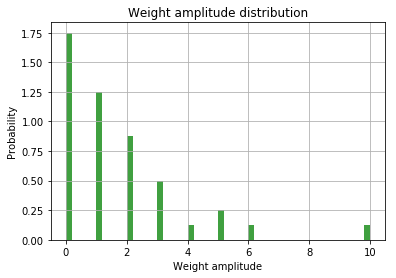

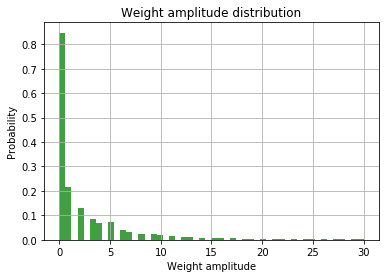

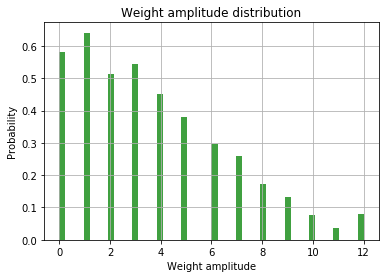

25 bits 33554432

Test set: Accuracy: 9202/10000 (92.02%)



In [22]:
model, data_prec = test_compression(prec=(1, 3, 3), comp=(2, 2, 4), rm_outlier_frac=99.9, show_distrib=True)

#prec=(1, 3, 3), comp=(2, 2, 4)

Here comes the test phase, which in very close to `learn.test`. However, as you see we convert the data into fixed precision, and instead of a full forward pass, we omit the last log_softmax (by using `.transform()`) as it should not be applied in the encryption part so not be applied on the integers. Hence, we apply it after the output is converted back to float.

Export the model for RITD

In [18]:
model.proj1.weight.t().shape

torch.Size([784, 40])

In [19]:
proj = torch.cat((model.proj1.bias.reshape(1, 40) / 10**data_prec, model.proj1.weight.t()), 0)
proj = proj.tolist()
diag = model.diag1.weight.t().tolist()

In [20]:
import pickle

In [21]:
assert len(proj) == (784 + 1)
assert len(proj[0]) == len(diag)
assert len(diag[0]) == 26
model = (proj,diag)

with open('/Users/tryffel/code/reading-in-the-dark/mnist/objects/ml_models/torch_cl_large.mlm', 'wb') as f:
    pickle.dump(model, f)